<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: преподаватель Факультета Компьютерных Наук НИУ ВШЭ <br> Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 8. Продвинутые методы классификации и регрессии</center>
## <center>Часть 5. Оценка важности признаков с Xgboost</center>

## Загрузка бибилиотек

In [1]:
%pylab inline
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(font_scale = 1.5)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


## Загрузка и подготовка данных

Посмотрим на примере данных по оттоку клиентов из телеком-компании.### Load data<a name='data' />

In [2]:
df = pd.read_csv('../../data/telecom_churn.csv')

In [3]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


**Штаты просто занумеруем, а признаки International plan (наличие международного роуминга), Voice mail plan (наличие голосовой почтыы) и целевой Churn сделаем бинарными.**

In [4]:
state_enc = LabelEncoder()
df['State'] = state_enc.fit_transform(df['State'])
df['International plan'] = (df['International plan'] == 'Yes').astype('int')
df['Voice mail plan'] = (df['Voice mail plan'] == 'Yes').astype('int')
df['Churn'] = (df['Churn']).astype('int')

**Разделим данные на обучающую и тестовую выборки в отношении 7:3. Инициализируем соотв. объекты DMatrix dtrain и dtest.**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Churn', axis=1), df['Churn'],
                                                    test_size=0.3, random_state=42)
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

### Обучение модели

**Обучим всего 5 деревьев решений глубины 3.**

In [6]:
params = {
    'objective':'binary:logistic',
    'max_depth':3,
    'silent':1,
    'eta':0.5
}

num_rounds = 5

In [7]:
watchlist  = [(dtest,'test'), (dtrain,'train')] # native interface only
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-error:0.1	train-error:0.091299
[1]	test-error:0.09	train-error:0.088298
[2]	test-error:0.073	train-error:0.067724
[3]	test-error:0.067	train-error:0.060437
[4]	test-error:0.058	train-error:0.046292


### Важность признаков

**F score при оценке важности признаков в Xgboost (не путать с F1 score как метрики качества классификации) вычисляется на основе того, как часто разбиение делалось по данному признаку.**

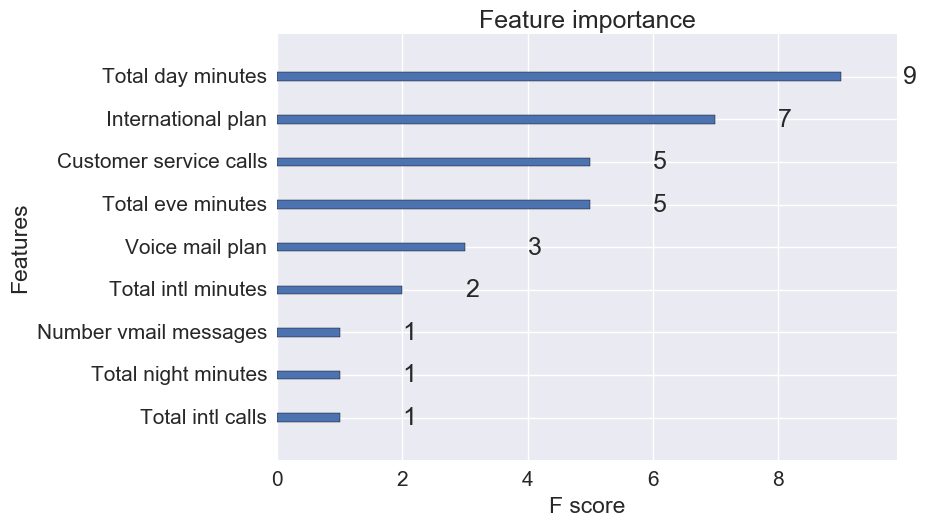

In [8]:
xgb.plot_importance(xgb_model)

**Можно так, в виде словаря или DataFrame:**

In [9]:
importances = xgb_model.get_fscore()
importances

{'Customer service calls': 5,
 'International plan': 7,
 'Number vmail messages': 1,
 'Total day minutes': 9,
 'Total eve minutes': 5,
 'Total intl calls': 1,
 'Total intl minutes': 2,
 'Total night minutes': 1,
 'Voice mail plan': 3}

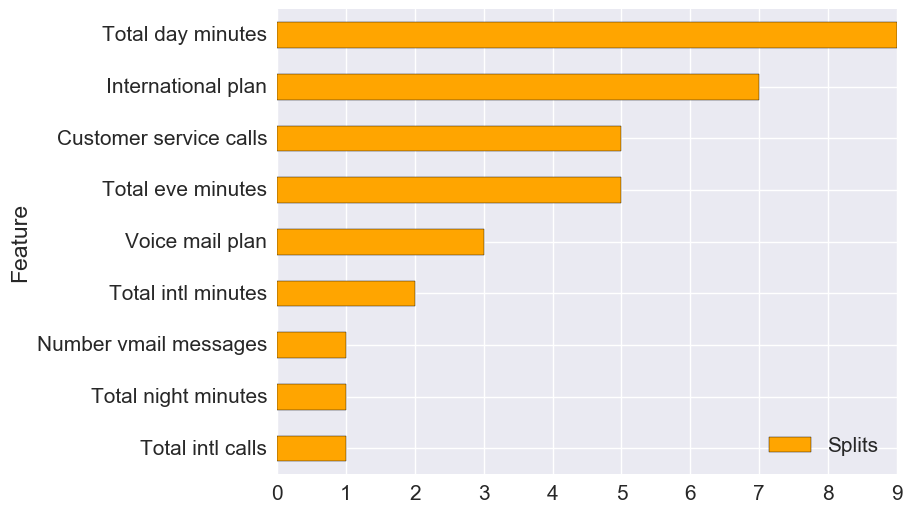

In [10]:
# create df
importance_df = pd.DataFrame({
        'Splits': list(importances.values()),
        'Feature': list(importances.keys())
    })
importance_df.sort_values(by='Splits', inplace=True)
importance_df.plot(kind='barh', x='Feature', figsize=(8,6), color='orange')